This notebook performs a rough estimate of the dynamic parameters estimation of the equivalent circuit model, using a simple current step.

In [176]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib notebook

In [177]:
log_file = 'motor_test.log'
df = pd.read_csv(log_file,sep='\t',header=None, names=['timestamp','index','msg','value'])

In [178]:
grouped = df.groupby('msg')
for msg,group in grouped:
    if msg == 'M1:BATTERY_STATUS.current_battery':
        time = group['timestamp']/1e3
        time.name = 'time'
        time.index=range(len(time))
        current = group['value']/1e2
        current.name = 'current'
        current.index=range(len(current))
        
    elif msg == 'M1:BATTERY_STATUS.voltages.0':
        voltage = group['value']/1e3
        voltage.name = 'voltage'
        voltage.index=range(len(voltage))

<IPython.core.display.Javascript object>


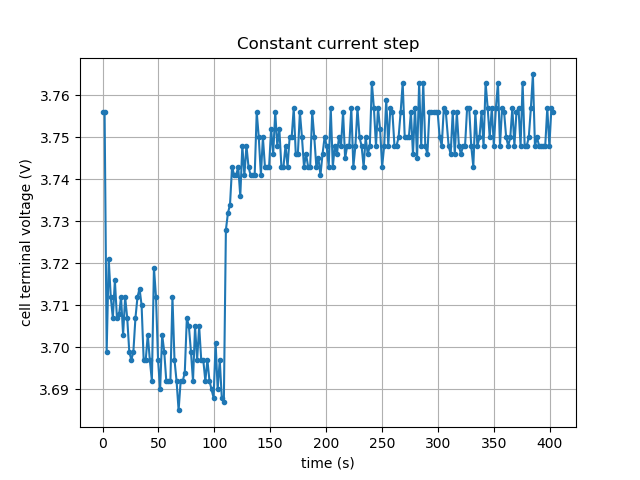

In [179]:
plt.figure()
plt.plot(time,voltage,'.-')
plt.xlabel('time (s)')
plt.ylabel('cell terminal voltage (V)')
plt.title('Constant current step')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


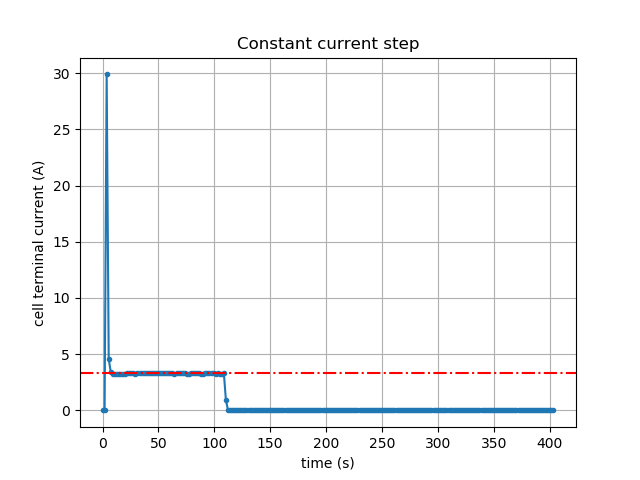

In [180]:
plt.figure()
plt.plot(time,current,'.-')
plt.axhline(3.3,color='r',linestyle='-.')
plt.xlabel('time (s)')
plt.ylabel('cell terminal current (A)')
plt.title('Constant current step')
plt.grid()
plt.show()

### Using Ballparking Method

In [181]:
current[59:63]

59    3.34
60    0.93
61    0.04
62    0.00
Name: current, dtype: float64

In [134]:
voltage[57:64]

57    3.697
58    3.688
59    3.687
60    3.728
61    3.732
62    3.734
63    3.743
Name: voltage, dtype: float64

In [182]:
dv0 = voltage[60]-voltage[59]
di = current[59]-current[62]
print(di)

3.34


In [183]:
R0 = dv0/di
print(f'R0 = {R0} Ohm')

R0 = 0.012275449101796518 Ohm


In [184]:
vss = np.mean(voltage[time>300])
dvss = vss - voltage[59]
R1 = (dvss - dv0)/di
print(f'R1 = {R1} Ohm')
print(R0+R1)

R1 = 0.007255132591958727 Ohm
0.019530581693755246


In [185]:
time.index[time>250]

Int64Index([136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
            149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
            162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
            175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
            188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
            201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
            214, 215, 216, 217, 218, 219],
           dtype='int64')

In [186]:
dtime = time[136]-time[59]

In [187]:
C1 = dtime/(5*R1)
print(f'C1 = {C1/1e3} kF')

C1 = 3.9050147796611308 kF


### Simulation for parameters validation

In [289]:
import sys 
sys.path.append('/home/lucas/Documents/Battery')
from battery import Thevenin

In [302]:
dt = np.mean(np.diff(time))
Q = 6600 # mAh
z0 = 0.39

In [303]:
battery = Thevenin(z0,Q,R0,R1,C1)
battery.setOCVfromcsv('/home/lucas/Documents/Log_Analysis/Battery/SOCvsOCV.csv')
OCVfromSOC = battery.OCVfromSOC()
print(type(OCVfromSOC))

<class 'scipy.interpolate.interpolate.interp1d'>


In [304]:
vsim = battery.simulate(time,current,OCVfromSOC)

<IPython.core.display.Javascript object>


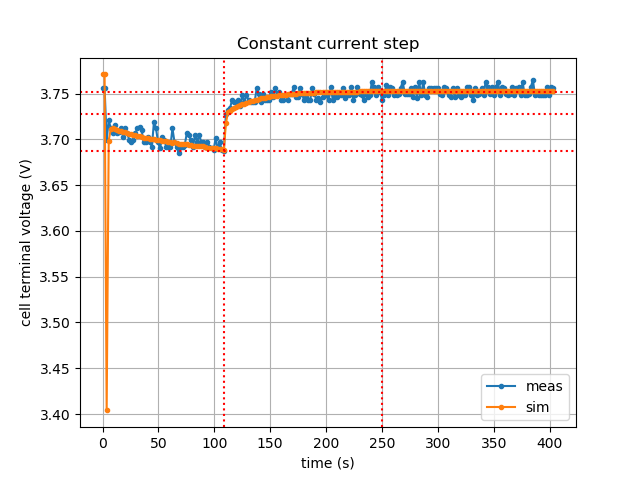

In [305]:
plt.figure()
plt.plot(time,voltage,'.-',label='meas')
plt.plot(time,vsim,'.-',label='sim')
plt.axhline(voltage[59],color='r',linestyle=':')
plt.axhline(voltage[60],color='r',linestyle=':')
plt.axhline(vss,color='r',linestyle=':')
plt.axvline(time[59],color='r',linestyle=':')
plt.axvline(time[136],color='r',linestyle=':')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('cell terminal voltage (V)')
plt.title('Constant current step')
plt.grid()
plt.show()

In [301]:
import csv 
csv_file = open('ECparams.csv','w')
writer = csv.writer(csv_file)
writer.writerow(['z','R0','R1','C1'])
writer.writerow([z0,R0,R1,C1])

66

### Using global optimization method

In [220]:
from scipy import optimize
def error(param):
    optbattery = Thevenin(z0,Q,param[0],param[1],param[2])
    vsim = optbattery.simulate(time,current,OCVfromSOC)
    error = np.sum((vsim-voltage)**2)
    return error

bounds = [(1e-5,1e-4),(1e-5,.1),(1e-5,10e3)]
# results = optimize.dual_annealing(error,bounds)
results = optimize.differential_evolution(error,bounds)
print(results)

     fun: 0.01915071443468427
     jac: array([-5.11565970e+00, -1.31943068e-06,  1.98903394e-06])
 message: 'Optimization terminated successfully.'
    nfev: 646
     nit: 13
 success: True
       x: array([1.00000000e-04, 1.71960493e-02, 8.51972341e+02])


In [221]:
optbattery = Thevenin(z0,Q,results.x[0],results.x[1],results.x[2])
vsimopt = optbattery.simulate(time,current,OCVfromSOC)

<IPython.core.display.Javascript object>


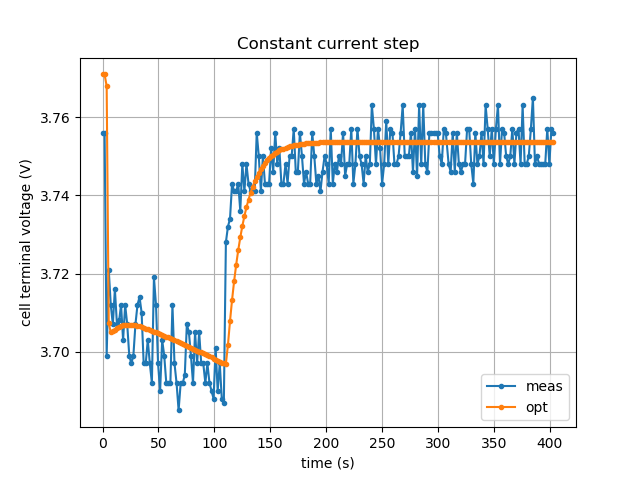

In [222]:
plt.figure()
plt.plot(time,voltage,'.-',label='meas')
plt.plot(time,vsimopt,'.-',label='opt')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('cell terminal voltage (V)')
plt.title('Constant current step')
plt.grid()
plt.show()


In [223]:
error = np.sum((vsimopt - voltage)**2)
print(error)

0.01915071443468427


In [215]:
import csv 
csv_file = open('ECparams.csv','w')
writer = csv.writer(csv_file)
writer.writerow(['z','R0','R1','C1'])
writer.writerow([z0,results.x[0],results.x[1],results.x[2]])

66